# Surname nationality classifying

## Parameters

In [ ]:
dataset_path = '../datasets/surnames_by_nationality/*.txt'
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

## Loading 

In [17]:
from io import open
import glob
import os
import unicodedata
import string

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

for example in ['Ślusàrski', 'Frazão', 'Muçlu', 'François', 'áéíóú âêîôû äëïöü àèìòù ãõ']:
    print('ASCII conversion: "' + example + '" -> "' + unicodeToAscii(example) + '"')

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob(dataset_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print("First 5 italian names:", category_lines['Italian'][:5])

ASCII conversion: "Ślusàrski" -> "Slusarski"
ASCII conversion: "Frazão" -> "Frazao"
ASCII conversion: "Muçlu" -> "Muclu"
ASCII conversion: "François" -> "Francois"
ASCII conversion: "áéíóú âêîôû äëïöü àèìòù ãõ" -> "aeiou aeiou aeiou aeiou ao"
First 5 italian names: ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [45]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(lineToTensor('abc.'))
letter_positions = [str(i) + ': ' + c for i, c in enumerate(list(all_letters))]
print('Tensor positions: ', letter_positions)

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [19]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print('Created rnn:', rnn)

Created rnn: RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [20]:
input = lineToTensor('Untrained')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9344, -2.7979, -2.8507, -2.8518, -2.9035, -2.8160, -2.9274, -2.9102,
         -2.8480, -2.8953, -2.9198, -2.8869, -2.8957, -2.8945, -2.9357, -2.9292,
         -2.8549, -2.9943]], grad_fn=<LogSoftmaxBackward0>)


In [21]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 1)


In [22]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Sepulveda
category = German / line = Best
category = Spanish / line = Orellana
category = Irish / line = Flynn
category = Spanish / line = Torres
category = Japanese / line = Onishi
category = English / line = Eaton
category = Korean / line = Bang
category = English / line = Roche
category = Vietnamese / line = Doan


In [23]:
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [24]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 3.2582 Jelen / Irish ✗ (Polish)
10000 10% (0m 4s) 1.6420 Tsai  / Arabic ✗ (Korean)
15000 15% (0m 6s) 1.2249 Chau / Chinese ✗ (Vietnamese)
20000 20% (0m 8s) 2.0855 Giroux / Arabic ✗ (French)
25000 25% (0m 10s) 1.2869 Chi / Korean ✗ (Chinese)
30000 30% (0m 13s) 2.1713 Richard / French ✗ (German)
35000 35% (0m 15s) 2.3993 Shintaro / Portuguese ✗ (Japanese)
40000 40% (0m 17s) 2.0302 Dubois / Arabic ✗ (French)
45000 45% (0m 19s) 1.5427 Toma / Japanese ✗ (Arabic)
50000 50% (0m 21s) 1.6015 Janin / Korean ✗ (Russian)
55000 55% (0m 23s) 0.0067 Shibasawa / Japanese ✓
60000 60% (0m 25s) 1.9674 Lawrenz / Spanish ✗ (German)
65000 65% (0m 28s) 0.5479 Trinh / Vietnamese ✓
70000 70% (0m 30s) 1.3544 Gagne / Italian ✗ (French)
75000 75% (0m 32s) 0.2795 Harb / Arabic ✓
80000 80% (0m 34s) 0.4473 Sevriens / Dutch ✓
85000 85% (0m 36s) 0.1043 Turunov / Russian ✓
90000 90% (0m 39s) 1.9993 Cuevas / Greek ✗ (Spanish)
95000 95% (0m 41s) 0.4320 Ibu / Japanese ✓
100000 100% (0m 43s) 3.2924 Kuhn / V

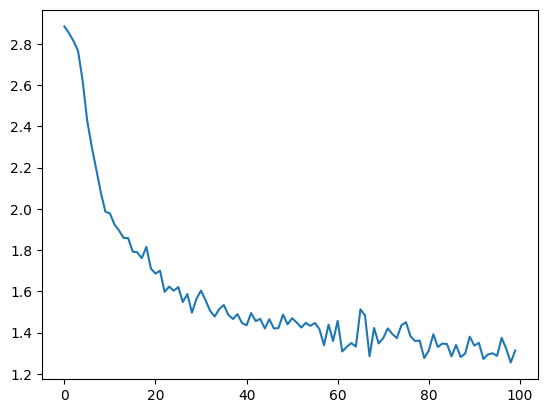

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/var/folders/7f/9f_9q2ld6m3633v17rqfgd400000gn/T/ipykernel_82527/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/7f/9f_9q2ld6m3633v17rqfgd400000gn/T/ipykernel_82527/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


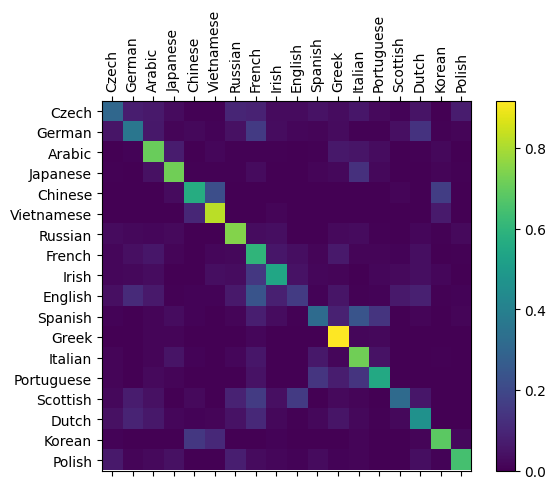

In [26]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [27]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Oleary')
predict('Frazao')
predict('Ramirez')
predict('Takahashi')


> Dovesky
(-0.44) Russian
(-1.14) Czech
(-4.14) English

> Jackson
(-1.13) English
(-1.16) Russian
(-1.91) Scottish

> Satoshi
(-1.16) Italian
(-1.24) Japanese
(-1.27) Arabic

> Oleary
(-0.68) French
(-1.31) Irish
(-1.91) English

> Frazao
(-0.74) Portuguese
(-1.09) Spanish
(-1.85) Italian

> Ramirez
(-0.39) Spanish
(-1.37) Portuguese
(-3.65) Polish

> Takahashi
(-0.75) Italian
(-0.76) Japanese
(-2.98) Greek
